# 7. 다대일 RNN 기본 Modeling

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets
import random
from torchtext.data import TabularDataset

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

cpu와 cuda 중 다음 기기로 학습함: cpu


## 7-1. Review Data 수집 및 전처리

In [2]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x28a2c456d08>)

In [3]:
import pandas as pd

df = pd.read_csv('IMDb_Reviews.csv', encoding='latin1')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [4]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 50000


In [5]:
# Sample 수가 많으므로, Test용으로 대폭 줄여 새로운 파일을 만든 후 사용
df = pd.read_csv('IMDb_Reviews_test.csv', encoding='latin1')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,It would be unfair to the actors to condemn th...,0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [6]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 20


### 훈련 데이터, 평가 데이터, 테스트 데이터로 분리

In [7]:
train_df = df[:15]
test_df = df[15:]

In [8]:
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

## 7-2. Field 정의 및 Dataset 만들기

In [9]:
TEXT = data.Field(sequential=True,lower=True, batch_first=True)
LABEL = data.Field(sequential=False, batch_first=True)

In [10]:
trainset, testset = TabularDataset.splits(
        path='.', train='train_data.csv', test='test_data.csv', format='csv',
        fields=[('text', TEXT), ('label', LABEL)], skip_header=True)

### Dataset sample 확인

In [11]:
print('훈련 샘플의 개수 : {}'.format(len(trainset)))
print('테스트 샘플의 개수 : {}'.format(len(testset)))

훈련 샘플의 개수 : 15
테스트 샘플의 개수 : 5


In [12]:
print(trainset[0])

In [13]:
# trainset 내용물 확인
print(vars(testset[0]))

{'text': ['in', 'truth', 'though,', "there's", 'a', 'lack', 'of', 'dramatic', 'tension', 'throughout', 'for', 'which', 'the', 'action', 'sequences', "don't", 'fully', 'compensate', 'and', 'you', "don't", 'care', 'a', 'fig', 'for', 'any', 'of', 'the', 'leading', 'characters.', 'one', 'of', 'those', 'films', 'where', 'the', 'actors', 'probably', 'enjoyed', 'making', 'it', 'more', 'than', 'the', 'viewers', 'did', 'watching', 'it.'], 'label': '0'}


## 7-3. Vocabulary set 만들기

In [14]:
TEXT.build_vocab(trainset, min_freq=3)          # 단어 집합 생성, 단어 수가 적으므로 최소 사용 횟수를 3으로 설정
LABEL.build_vocab(trainset)

In [15]:
n_vocab = len(TEXT.vocab)
print('단어 집합의 크기 : {}'.format(n_vocab))

단어 집합의 크기 : 33


In [16]:
# 수집된 전체 단어 확인
print(TEXT.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x00000258601BB6C8>>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'of': 3, 'to': 4, 'and': 5, 'a': 6, 'it': 7, 'i': 8, 'one': 9, 'is': 10, 'this': 11, 'was': 12, 'in': 13, 'that': 14, 'but': 15, 'ever': 16, 'you': 17, 'are': 18, 'for': 19, 'movie': 20, 'be': 21, 'by': 22, 'first': 23, 'had': 24, "it's": 25, 'just': 26, 'make': 27, 'most': 28, 'movies': 29, 'not': 30, 'there': 31, 'they': 32})


In [17]:
trainset_2, valset = trainset.split(split_ratio=0.45)       # 훈련 데이터와 평가 데이터 분리

In [18]:
print('훈련 샘플의 개수 : {}'.format(len(trainset_2)))
print('평가 샘플의 개수 : {}'.format(len(valset)))

훈련 샘플의 개수 : 7
평가 샘플의 개수 : 8


## 7-4. Data loader

### Dataloader test

In [22]:
BATCH_SIZE = 2

train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset_2, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False, sort=False)                            # shuffle 진행 안하면 Data 변환 추적 쉬움.

In [23]:
print('훈련 데이터의 미니 배치의 개수 : {}'.format(len(train_iter)))
print('검증 데이터의 미니 배치의 개수 : {}'.format(len(val_iter)))
print('테스트 데이터의 미니 배치의 개수 : {}'.format(len(test_iter)))

훈련 데이터의 미니 배치의 개수 : 4
검증 데이터의 미니 배치의 개수 : 4
테스트 데이터의 미니 배치의 개수 : 3


In [26]:
batch = next(iter(train_iter))       # Dataloader가 iterator 역할을 잘하는지 확인
print(batch)


[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x53]
	[.label]:[torch.LongTensor of size 2]


In [27]:
batch2 = next(iter(val_iter))      # data.BucketIterator.splits 조건에 sort=False를 하지 않으면  " '<' not supported ... " Error 발생
print(batch2)


[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x53]
	[.label]:[torch.LongTensor of size 2]


In [28]:
print('훈련 데이터의 샘플의 개수 재확인 : {}'.format(len(train_iter.dataset)))
print('검증 데이터의 샘플의 개수 재확인 : {}'.format(len(val_iter.dataset)))
print('테스트 데이터의 샘플의 개수 재확인 : {}'.format(len(test_iter.dataset)))

훈련 데이터의 샘플의 개수 재확인 : 7
검증 데이터의 샘플의 개수 재확인 : 8
테스트 데이터의 샘플의 개수 재확인 : 5


### batch Iterator test

In [29]:
for b, batch in enumerate(train_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    print('b is {}. batch is {}'. format(b, batch)) 

b is 0. batch is 
[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x31]
	[.label]:[torch.LongTensor of size 2]
b is 1. batch is 
[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x53]
	[.label]:[torch.LongTensor of size 2]
b is 2. batch is 
[torchtext.data.batch.Batch of size 2]
	[.text]:[torch.LongTensor of size 2x49]
	[.label]:[torch.LongTensor of size 2]
b is 3. batch is 
[torchtext.data.batch.Batch of size 1]
	[.text]:[torch.LongTensor of size 1x44]
	[.label]:[torch.LongTensor of size 1]


In [30]:
for b, batch in enumerate(train_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    print('x is {}. y is {}'. format(x, y)) 
    print(y.data.sub_(1))      # lable 값 조정: y값에서 () 값을 뺌, sub 대신 add를 하면 더함

x is tensor([[ 2,  9,  0, 10,  2,  0,  4,  0, 13,  0,  0,  0,  0,  0,  0,  0,  4,  0,
          0, 13,  2,  0,  0, 11, 26,  0,  2,  0,  6,  0,  0,  0, 15,  0, 17,  0,
          0,  0,  0, 17,  0,  0,  6,  0,  0,  4,  0,  0,  0],
        [31, 10,  0,  0, 14,  0, 10, 22,  0,  9,  3,  2,  0,  0, 16, 30,  0, 13,
          0,  0, 15,  0,  0,  0,  2,  0,  0,  0,  0,  2,  0,  7,  0,  0,  0,  0,
          3,  0,  0,  7,  0,  4,  0,  0,  1,  1,  1,  1,  1]]). y is tensor([1, 1])
tensor([0, 0])
x is tensor([[ 0,  0,  5,  8,  0,  0, 30,  0,  0, 29, 19,  2,  0,  0, 14, 32, 18,  0,
          0, 32,  0,  2,  0,  5, 26, 30,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1],
        [ 7, 10,  0,  5,  8,  0,  7,  4,  0, 17,  0,  0,  0,  0,  5,  0,  5,  0,
          0,  0, 19,  0,  5,  0,  3,  0,  0,  4,  0,  8,  0,  7,  0,  0,  5,  0,
          8,  0,  4,  0,  0,  0,  0]]). y is tensor([1, 1])
tensor([0, 0])
x is tensor([[ 8,  0,  2,  0,  3, 11,  5,  8, 12,  0,  0,  0,  0,  0

In [31]:
 x            # 현재 x 입력값 확인

tensor([[ 7, 12,  2,  0,  5,  0,  0,  0,  0,  5,  6,  0,  0,  0,  0,  0,  0,  4,
         27,  6,  0,  0,  0,  0,  0,  0,  3, 11,  0,  0, 12,  0,  4,  0,  2,  0,
          0, 10,  9,  3,  2, 28,  0,  0,  0, 16,  0,  6,  0,  4, 27,  6,  0]])

In [32]:
 x.shape  

torch.Size([1, 53])

In [33]:
y

tensor([1])

## 7-5. Reviewing RNN Model

* Embedding, RNN, Cost Function 동작 확인

### hyperparameters

In [34]:
n_classes = 2   # 분류되어야 할 결과 수 (긍정 or 부정)
embed_dim= 5  # 임베딩 된 차원의 크기 및 RNN 층 입력 차원의 크기
hidden_size = 20  # RNN의 은닉층 크기

### Embedding Test

In [35]:
# num_embedding는 trainset 단어 전체 갯수인 n_vocab로 지정
Emb_Test=nn.Embedding(num_embeddings=n_vocab,   embedding_dim=embed_dim)
print(Emb_Test.weight)

Parameter containing:
tensor([[ 1.8423e+00,  5.1889e-01, -1.7119e+00, -1.7014e+00,  2.0194e+00],
        [-2.6861e-01, -1.3072e-01, -1.4374e+00,  3.9077e-01, -1.8968e-02],
        [-1.3527e+00, -7.3082e-01,  9.8792e-01, -4.1941e-01, -5.8490e-01],
        [-7.8233e-01,  2.7799e+00,  1.2220e+00, -3.3645e-01, -9.6506e-01],
        [-1.2966e-01, -6.0177e-01,  1.4500e-01, -1.4983e-01, -4.3740e-01],
        [ 7.7923e-01, -5.8339e-02, -2.0305e+00,  1.4829e+00,  4.9404e-01],
        [ 2.4922e-01,  1.7470e+00, -2.6167e-01, -7.3239e-01,  1.6980e+00],
        [-1.7917e-01,  1.9231e+00,  2.8795e-01,  9.3680e-01, -2.4031e+00],
        [-1.4789e-01,  8.9670e-01,  5.4813e-01, -1.6391e+00, -1.8153e+00],
        [-2.0663e-01, -5.2595e-01, -1.6977e+00,  8.1679e-01,  4.0964e-01],
        [ 2.1623e-01,  1.0898e+00,  1.7303e-01,  1.6677e-01, -1.1372e+00],
        [-8.2083e-01, -1.7927e+00,  8.7719e-01,  2.1641e+00, -1.8553e-01],
        [ 9.9064e-01,  7.4259e-01,  1.2702e+00,  1.3227e+00, -5.1811e-01],
   

In [36]:
Emb_Test(x).shape           # 임베딩 결과 차원 확인

torch.Size([1, 53, 5])

### RNN input Test

In [37]:
rnn_test = nn.RNN(embed_dim, hidden_size, batch_first=True)

In [38]:
output, hidden = rnn_test (Emb_Test(x))      # Tuple 형태의 결과를 분리
output.shape

torch.Size([1, 53, 20])

In [39]:
output

tensor([[[-0.3476,  0.3406,  0.4418,  ..., -0.8358,  0.5103, -0.3813],
         [-0.8339,  0.4391,  0.2956,  ..., -0.4438,  0.1044, -0.2850],
         [-0.6092,  0.1649,  0.4299,  ..., -0.4201, -0.5689, -0.5137],
         ...,
         [-0.0237,  0.0577,  0.2442,  ..., -0.1295, -0.5892, -0.1148],
         [-0.3771,  0.3087,  0.6000,  ..., -0.1882, -0.3551, -0.2562],
         [-0.2805, -0.0598,  0.3699,  ...,  0.2670, -0.7350, -0.0822]]],
       grad_fn=<TransposeBackward1>)

### Return Analysis

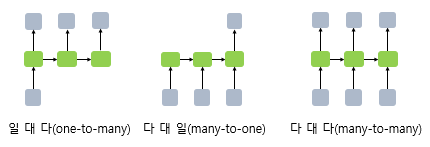

* 리뷰 감성 분류는 긍정/부정 하나의 분류이므로, RNN 다대일 구조이며, 이 경우 RNN 연산 결과는 n개 은닉 상태 중에서 마지막 번째만 선택

In [40]:
output[:, -1, :]

tensor([[-0.2805, -0.0598,  0.3699, -0.0104, -0.4839,  0.8506,  0.1663,  0.6903,
         -0.0231, -0.6711, -0.5414,  0.0972, -0.3279, -0.1136, -0.8845, -0.5998,
          0.6288,  0.2670, -0.7350, -0.0822]], grad_fn=<SliceBackward>)

### Linear Regression test for Binary Selection

In [41]:
linear_test = nn.Linear(hidden_size, n_classes)
linear_test(output[:, -1, :])

tensor([[ 0.0819, -0.0214]], grad_fn=<AddmmBackward>)

### Cost function Test

In [42]:
out = linear_test(output[:, -1, :])
F.cross_entropy(out, y)

tensor(0.7461, grad_fn=<NllLossBackward>)

## 7-6. Designing Model

### Simple Modeling

* Embedding -> RNN -> binary Classification

In [43]:
class myModel_1(nn.Module):
    def __init__(self, hidden_size, n_vocab, embed_dim, n_classes, batch_first=True):    
        super(myModel_1, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embed_dim)
        self.rnn_layer = nn.RNN(embed_dim, hidden_size, batch_first=batch_first)
        self.linear = nn.Linear(hidden_size, n_classes) 

    def forward(self, x):
        output = self.embedding_layer(x)
        output, hidden = self.rnn_layer(output)
        output = self.linear(output[:, -1, :])
        return output

In [44]:
# 모델 생성
simple_model = myModel_1(hidden_size, n_vocab, embed_dim, n_classes, batch_first=True)

In [45]:
simple_model(x)           # Model test

tensor([[-0.3953, -0.0669]], grad_fn=<AddmmBackward>)

In [46]:
optimizer = torch.optim.Adam(params=simple_model.parameters(), lr = 0.001)

### Model Training

In [47]:
for step in range(1, 201):
        for b, batch in enumerate(train_iter):
            x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
            y.data.sub_(1)  # 레이블 값을 0과 1로 변환
            optimizer.zero_grad()
            output = simple_model(x)
            loss = F.cross_entropy(output, y, reduction='sum')
            loss.backward()
            optimizer.step()
        if step % 20 == 0:
            print("[{:02d}/200] output is {}, y is {}, and loss is {:.4f} ".format(step, output.data, y, loss))

[20/200] output is tensor([[ 0.0869, -0.6773],
        [ 0.2227, -0.7069]]), y is tensor([0, 0]), and loss is 0.7150 
[40/200] output is tensor([[-0.6659,  0.2290]]), y is tensor([1]), and loss is 0.3426 
[60/200] output is tensor([[-1.1810,  0.7455],
        [ 0.5542, -1.1610]]), y is tensor([1, 1]), and loss is 2.0166 
[80/200] output is tensor([[ 0.5643, -1.1482],
        [ 0.5500, -1.0792]]), y is tensor([1, 0]), and loss is 2.0574 
[100/200] output is tensor([[ 1.0069, -1.4312],
        [ 1.0902, -1.7369]]), y is tensor([0, 0]), and loss is 0.1412 
[120/200] output is tensor([[ 0.8377, -1.4073],
        [ 1.1594, -1.6013]]), y is tensor([0, 0]), and loss is 0.1620 
[140/200] output is tensor([[ 0.4676, -1.0658],
        [ 1.6302, -2.1382]]), y is tensor([0, 0]), and loss is 0.2182 
[160/200] output is tensor([[-2.5481,  2.0482],
        [-1.5619,  0.8576]]), y is tensor([1, 1]), and loss is 0.0953 
[180/200] output is tensor([[-2.7683,  2.2466]]), y is tensor([1]), and loss is 0.0

## 7-7. Model Evaluation

In [48]:
corrects, total_loss = 0, 0
for b, batch in enumerate(val_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    y.data.sub_(1)
    output = simple_model(x)
    loss = F.cross_entropy(output, y, reduction='sum')
    total_loss += loss.item()
    corrects += (output.max(1)[1].view(y.size()).data == y.data).sum()
size = len(val_iter.dataset)
avg_loss = total_loss / size
avg_accuracy = 100.0 * corrects / size
print("val loss is {}, val accuracy is {}".format (avg_loss, avg_accuracy))

val loss is 0.7921548443846405, val accuracy is 62.5
